## Design of Experiments (Method-focused)

Purpose: validate maximal continuous reasons and anti-reasons on a representative subset of UCR univariate time-series datasets, using our distributed method.

- Selection source: the dataset notebook builds `results/doe_selection.csv`, stratified by EU complexity (simple/middle/hard). This notebook reuses that file; it does not re-derive or tabulate dataset properties here.
- Inclusion criteria: EU metrics present in `forest_report.json`; fixed train/test splits; reasonable class balance; preference for datasets with existing result archives in `results/` to accelerate verification.
- Cohorts: simple (lowest eu_complexity), middle (around the median), hard (highest eu_complexity); balanced sample sizes subject to availability.
- Model setup: Random Forest (50 trees) trained per dataset (or reused), endpoints universe (EU) extracted from internal thresholds.
- Method: compute reasons via distributed workers coordinated by a key–value store; prune via ICF and profile domination; confirm maximality by attempted left/right feature extensions.
- Validation outcomes: for each dataset, persist reason/anti-reason artifacts and profiles (GP/BP/AP), and logs for reproducibility; aggregate metrics are summarized in the dataset notebook only.
- Compute considerations: prefer workers collocated with the key–value store to minimize latency; 4–8 host workers recommended; remote workers optional when horizontally scaling.


# Results archive inspection

This notebook automatically inspects every `.zip` file stored in the `results` directory.
It parses the filename of each archive to extract useful metadata, relies on the included
`manifest.json` file to map Redis database dumps to their logical meaning, and previews
all extracted files directly below. Large files are truncated to the first bytes so the
notebook stays responsive.

In [1]:
from pathlib import Path
from etl.loader import etl, build_db10_worker_report, render_bitmap_heatmaps, render_db0_eu_analysis, \
	render_db0_sample_timeseries, render_worker_report

RESULTS_DIR = Path("results")
zip_paths = sorted(RESULTS_DIR.glob("*.zip"))
db0_dict, selected_zip_name,selected_manifest, selected_backups, selected_archive_data, selected_manifest_prefix = etl(zip_paths, RESULTS_DIR)

Available ZIP archives:
[0] ECG200_-1_false_0.zip
[1] HandOutlines_0_false_0.zip
[2] MelbournePedestrian_1_false_0.zip
[3] MiddlePhalanxOutlineCorrect_0_false_0.zip
[4] SonyAIBORobotSurface1_1_false_0.zip
[5] Wine_1_false_0.zip
Current selection: [5] Wine_1_false_0.zip
DB 10: 2164 events, 32 workers for Wine_1_false_0.zip
- W01: records=85, iter=1–85, queue_avg=1833.2, car_queue_avg=754.1, queue_range=1.0-3588.0, car_queue_range=0.0-1274.0, h_tot=11.23, h_car=11.04, h_can=0.07
  car_results[CONFIRMED_AR:36, NOT_AR:45] | can_results[BAD:2, GOOD:83] | outcomes[bad=T:2, car_confirmed_ar=T:36, car_not_ar=T:45, good=T:83, pr_timestamp_added=T:3]
- W02: records=65, iter=1–65, queue_avg=1396.6, car_queue_avg=621.3, queue_range=1.0-2412.0, car_queue_range=0.0-1106.0, h_tot=10.29, h_car=10.21, h_can=0.01
  car_results[CONFIRMED_AR:31, NOT_AR:32] | can_results[BAD:2, GOOD:63] | outcomes[bad=T:2, car_confirmed_ar=T:31, car_not_ar=T:32, good=T:63, pr_timestamp_added=T:3]
- W03: records=67, iter=1–

In [2]:
from cost_function import cal_sigmas

training_set = db0_dict["TRAINING_SET"]["value_json"]
X_train = training_set["X_train"]
feature_names = training_set["feature_names"]

tests_sample = {}
X_test = []
test_ids = []

prefix = "sample_"
suffix = "_meta"

for raw_k, v in db0_dict.items():
	if isinstance(raw_k, str) and raw_k.startswith(prefix) and raw_k.endswith(suffix):
		sample_id = raw_k[len(prefix):-len(suffix)]
		meta = v["value_json"]

		tests_sample[sample_id] = {
			**meta,
			"features": meta["sample_dict"]
		}

		X_test.append(meta["sample_dict"])
		test_ids.append(sample_id)


sigmas_all = cal_sigmas(X_train, X_test, feature_names, test_ids=test_ids)

for sid in test_ids:
	tests_sample[sid]["sigmas"] = sigmas_all[sid]

In [2]:
	list_sample_radis = []
for i in range(len(X_test)):
	sample= db.get_metadata(i)
	list.append((sample_dict, test_index))

lista_ar = [ar.bitmpaToICF() for ar in DB ]
from cost_function import cost_function
pot_rob = {}
for (sample_dict, index) in list_sample_radis:
	for icf in lista_ar:
		c = cost_function(sample_dict, sigmas=sigmas_all, icf=icf, sample_index=index, verbose=True)
		print(f"Sample {index} Cost: {c}")

		pot_rob[index] = {'cost': c, 'icf':icf}
	robustness = max(pot_rob[index]['cost'])


In [3]:
DB10_WORKER_REPORT = build_db10_worker_report(selected_zip_name, selected_manifest, selected_backups, selected_archive_data, selected_manifest_prefix, max_events=None)

Report built for 32 workers.


Worker  Records  Iteration min  Iteration max  Queue min   Queue mean  \
0     W01       85              1             85        1.0  1833.164706   
1     W02       65              1             65        1.0  1396.569231   
2     W03       67              1             67        1.0  1537.492537   
3     W04       58              1             58        1.0  1182.344828   
4     W05       82              1             82        1.0  1578.853659   
5     W06       59              1             59        1.0  1189.525424   
6     W07       55              1             55        1.0  1053.618182   
7     W08       71              1             71        1.0  1398.633803   
8     W09       65              1             65        1.0  1240.107692   
9     W10       50              1             50        1.0   985.100000   
10    W11       59              1             59        1.0  1164.050847   
11    W12       52              1             52        1.0  1018.019231   
12    W13       71              1             71        1.0  1493.535211   
13    W14       73              1             73        1.0  1275.726027   
14    W15       52              1             52        1.0  1018.153846   
15    W16       59              1             59        1.0  1106.830508   
16    W17       70              1             70        1.0  1601.114286   
17    W18       70              1             70        1.0  1363.557143   
18    W19       58              1             58        1.0  1381.120690   
19    W20       86              1             86        1.0  1883.813953   
20    W21      103              1            103        1.0  2095.058252   
21    W22       64              1             64        1.0  1546.781250   
22    W23       56              1             56        1.0  1381.553571   
23    W24       83              1             83        1.0  1787.855422   
24    W25       68              1             68        1.0  1550.470588   
25    W26       59              1             59        1.0  1153.186441   
26    W27      108              1            108        1.0  1779.935185   
27    W28       61              1             61        1.0  1185.950820   
28    W29       63              1             63        1.0  1114.873016   
29    W30       58              1             58        1.0  1145.724138   
30    W31       80              1             80        1.0  1370.212500   
31    W32       54              1             54        1.0  1036.129630   

    Queue max  Candidate anti-reasons queue min  \
0      3588.0                               0.0   
1      2412.0                               0.0   
2      2813.0                               0.0   
3      2054.0                               1.0   
4      2688.0                               1.0   
5      2044.0                               1.0   
6      1840.0                               1.0   
7      2381.0                               1.0   
8      2205.0                               1.0   
9      1784.0                               1.0   
10     2077.0                               1.0   
11     1826.0                               1.0   
12     2823.0                               1.0   
13     2215.0                               1.0   
14     2143.0                               1.0   
15     2162.0                               1.0   
16     3410.0                               1.0   
17     2515.0                               1.0   
18     2417.0                               1.0   
19     3399.0                               1.0   
20     3508.0                               1.0   
21     2784.0                               1.0   
22     2499.0                               1.0   
23     3302.0                               1.0   
24     2716.0                               1.0   
25     2020.0                               1.0   
26     3392.0                               1.0   
27     2113.0                               1.0   
28     1873.0  

Detailed results per worker:


Worker  Candidate reasons result: Bad  Candidate reasons result: Good  \
0     W01                              2                              83   
1     W02                              2                              63   
2     W03                              1                              66   
3     W04                              0                              58   
4     W05                              1                              81   
5     W06                              0                              59   
6     W07                              0                              55   
7     W08                              0                              71   
8     W09                              0                              65   
9     W10                              0                              50   
10    W11                              0                              59   
11    W12                              0                              52   
12    W13                              1                              70   
13    W14                              1                              72   
14    W15                              1                              51   
15    W16                              3                              56   
16    W17                              2                              68   
17    W18                              1                              69   
18    W19                              0                              58   
19    W20                              1                              85   
20    W21                              1                             102   
21    W22                              0                              64   
22    W23                              0                              56   
23    W24                              1                              82   
24    W25                              0                              68   
25    W26                              0                              59   
26    W27                              5                             103   
27    W28                              0                              61   
28    W29                              0                              63   
29    W30                              0                              58   
30    W31                              1                              79   
31    W32                              0                              54   

    Candidate anti-reasons result: Confirmed  \
0                                         36   
1                                         31   
2                                         29   
3                                         30   
4                                         34   
5                                         26   
6                                         25   
7                                         29   
8                                         35   
9                                         29   
10                                        29   
11                                        24   
12                                        30   
13                                        29   
14                                        25   
15                                        26   
16                                        29   
17                                        32   
18                                        26   
19                                        31   
20                                        26   
21                                        30   
22                                        29   
23                                        28   
24                                        29   
25                                        32   
26                                        29   
27                                        26   
28                                        29   
29                                        27   
30    

C:\Users\danie\Projects\GitHub\IEEE_CAI\etl\loader.py:760: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  subset = subset[subset[[x_key, y_key]].applymap(lambda v: isinstance(v, (int, float))).all(axis=1)]


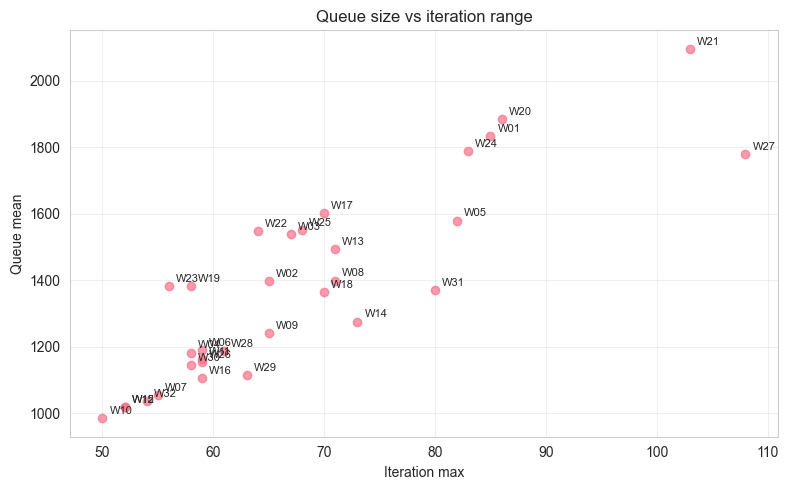

C:\Users\danie\Projects\GitHub\IEEE_CAI\etl\loader.py:760: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  subset = subset[subset[[x_key, y_key]].applymap(lambda v: isinstance(v, (int, float))).all(axis=1)]


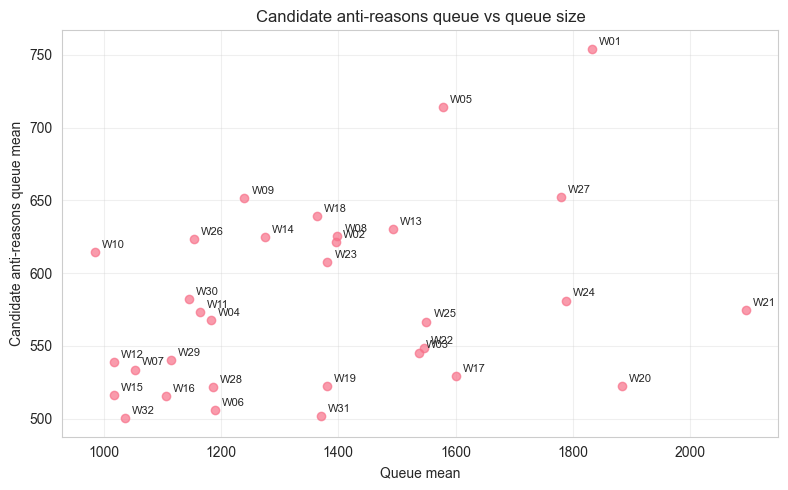

C:\Users\danie\Projects\GitHub\IEEE_CAI\etl\loader.py:760: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  subset = subset[subset[[x_key, y_key]].applymap(lambda v: isinstance(v, (int, float))).all(axis=1)]


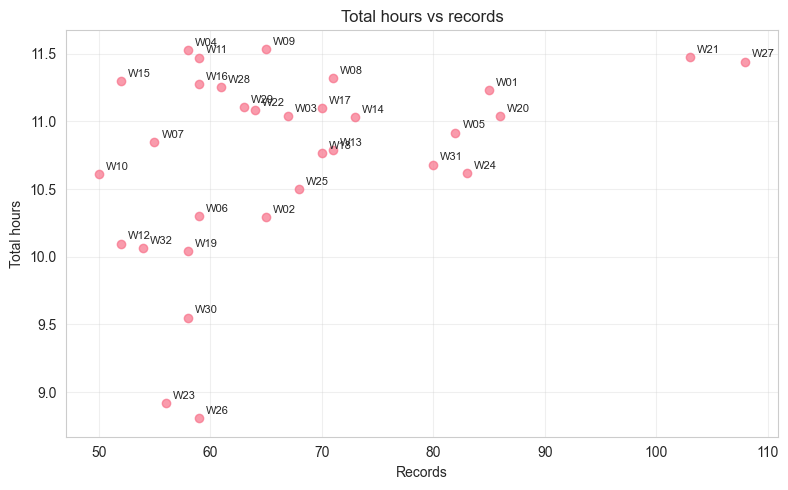

C:\Users\danie\Projects\GitHub\IEEE_CAI\etl\loader.py:760: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  subset = subset[subset[[x_key, y_key]].applymap(lambda v: isinstance(v, (int, float))).all(axis=1)]


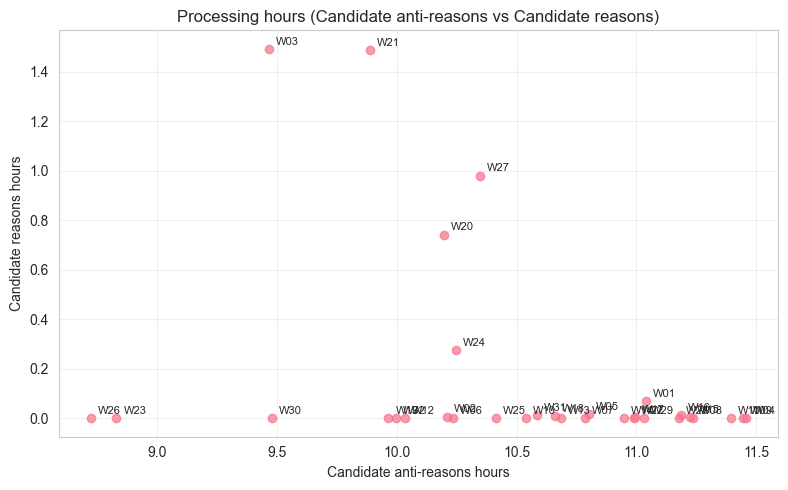

C:\Users\danie\Projects\GitHub\IEEE_CAI\etl\loader.py:760: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  subset = subset[subset[[x_key, y_key]].applymap(lambda v: isinstance(v, (int, float))).all(axis=1)]


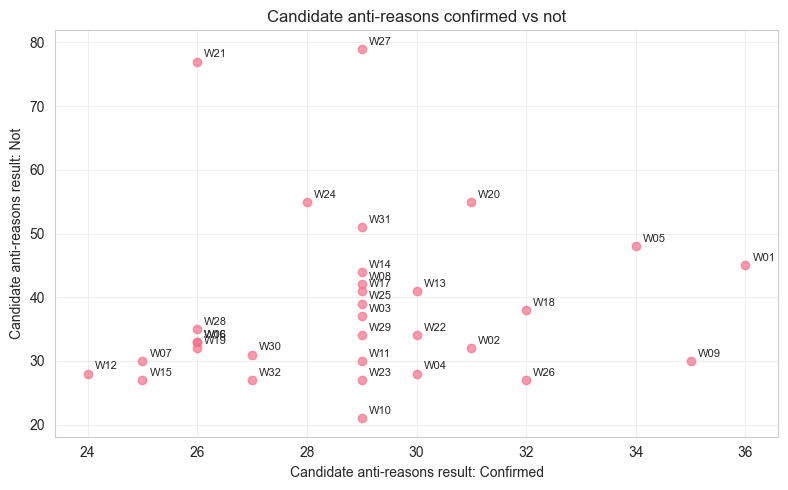

C:\Users\danie\Projects\GitHub\IEEE_CAI\etl\loader.py:760: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  subset = subset[subset[[x_key, y_key]].applymap(lambda v: isinstance(v, (int, float))).all(axis=1)]


<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

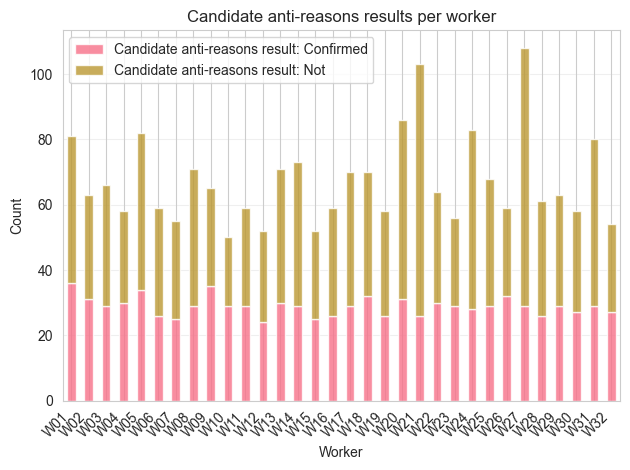

<Figure size 1600x500 with 0 Axes>

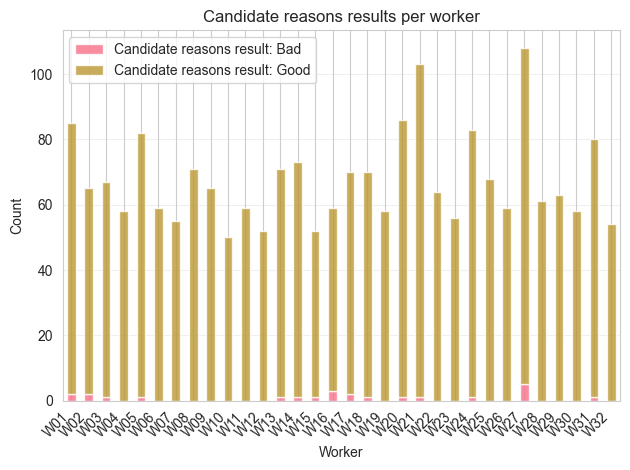

<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

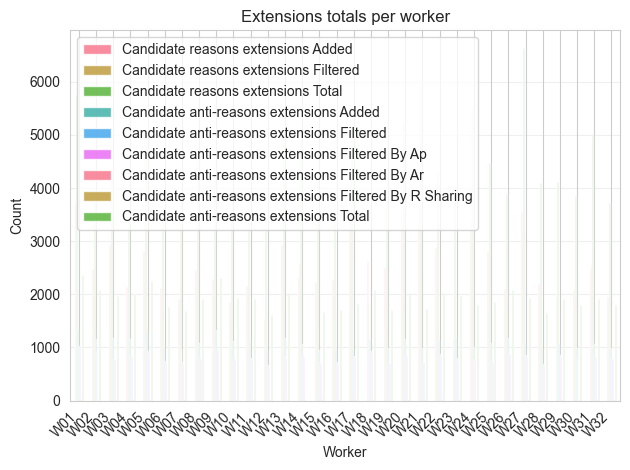

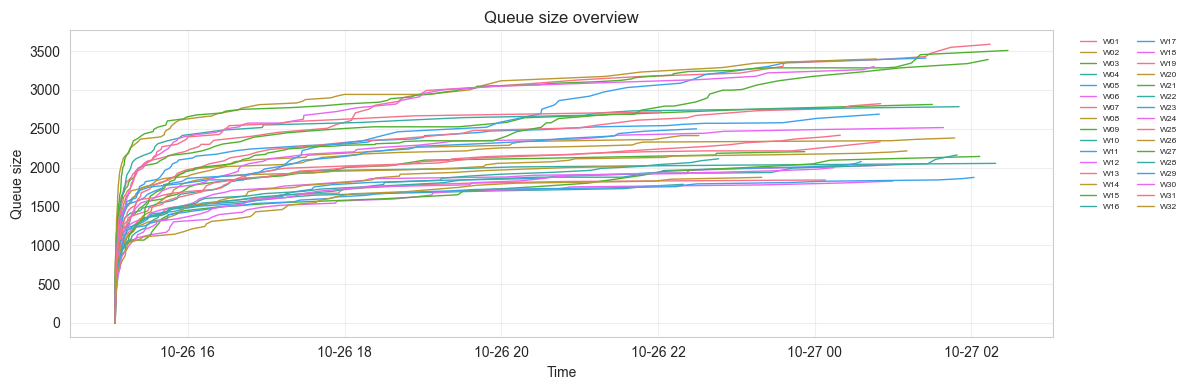

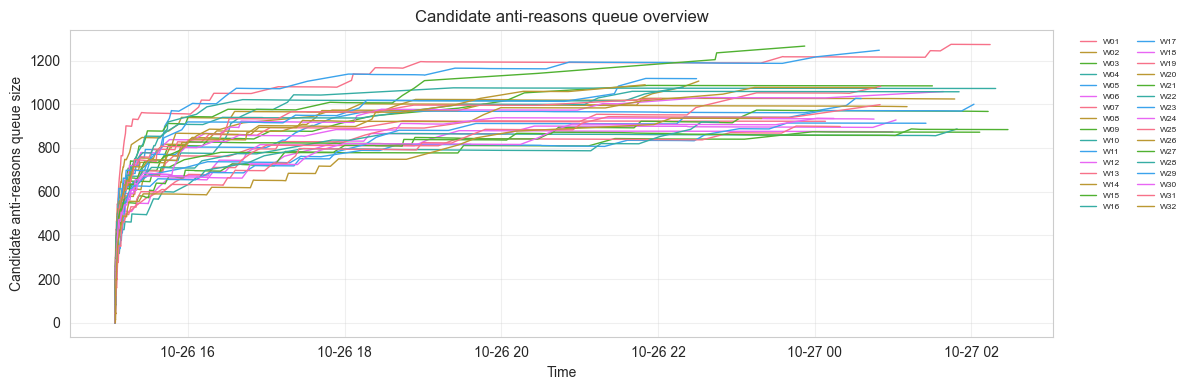

Worker iterations: 2164 rows across 32 workers.


Worker  Event order  Iteration                 Start time  \
0       W01            1          1 2025-10-26 15:04:12.469398   
1       W01            2          2 2025-10-26 15:04:12.780419   
2       W01            3          3 2025-10-26 15:04:13.097023   
3       W01            4          4 2025-10-26 15:04:13.336530   
4       W01            5          5 2025-10-26 15:04:13.544453   
...     ...          ...        ...                        ...   
2159    W32           50         50 2025-10-26 19:40:50.000480   
2160    W32           51         51 2025-10-26 20:10:54.968797   
2161    W32           52         52 2025-10-26 21:56:54.032097   
2162    W32           53         53 2025-10-26 22:10:02.134829   
2163    W32           54         54 2025-10-26 23:19:25.088997   

                       End time  Queue Size  \
0    2025-10-26 15:04:12.780356         1.0   
1    2025-10-26 15:04:13.096957        47.0   
2    2025-10-26 15:04:13.336464        92.0   
3    2025-10-26 15:04:13.544387       136.0   
4    2025-10-26 15:04:14.602172       136.0   
...                         ...         ...   
2159 2025-10-26 20:10:54.968694      1772.0   
2160 2025-10-26 21:56:54.031939      1799.0   
2161 2025-10-26 22:10:02.134696      1825.0   
2162 2025-10-26 23:19:25.088868      1850.0   
2163 2025-10-27 01:08:24.673758      1874.0   

      Candidate anti-reasons queue size  Total seconds  \
0                                   0.0       0.310950   
1                                   0.0       0.316535   
2                                   0.0       0.239438   
3                                   0.0       0.207854   
4                                   1.0       1.057716   
...                                 ...            ...   
2159                              846.0    1804.968208   
2160                              877.0    6359.063136   
2161                              907.0     788.102591   
2162                              936.0    4162.954031   
2163                              935.0    6539.584753   

      Candidate anti-reasons seconds  Candidate reasons seconds  ...  \
0                           0.000000                   0.005540  ...   
1                           0.000000                   0.003080  ...   
2                           0.000000                   0.002841  ...   
3                           0.000000                   0.207163  ...   
4                           0.169267                   0.002697  ...   
...                              ...                        ...  ...   
2159                     1795.336114                   0.094057  ...   
2160                     6350.262863                   0.095320  ...   
2161                      779.601135                   0.099489  ...   
2162                     4160.587004                   0.131994  ...   
2163                     6536.186141                   0.121841  ...   

     Candidate anti-reasons extensions Filtered By Ar  \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 1.0   
...                                               ...   
2159                                              0.0   
2160                                              0.0   
2161                                              0.0   
2162                                              NaN   
2163                                              NaN   

     Candidate anti-reasons extensions Filtered By R Sharing  \
0                                                   NaN        
1                                                   NaN        
2                                                   NaN        
3                                                   NaN        
4                                                   1.0        
...             

In [4]:
render_worker_report(selected_zip_name, selected_manifest, selected_backups, selected_archive_data, selected_manifest_prefix)

In [5]:
render_db0_eu_analysis()

DB 0 EU entry not available for the current selection.


In [6]:
render_db0_sample_timeseries()

No DB 0 sample time series available.


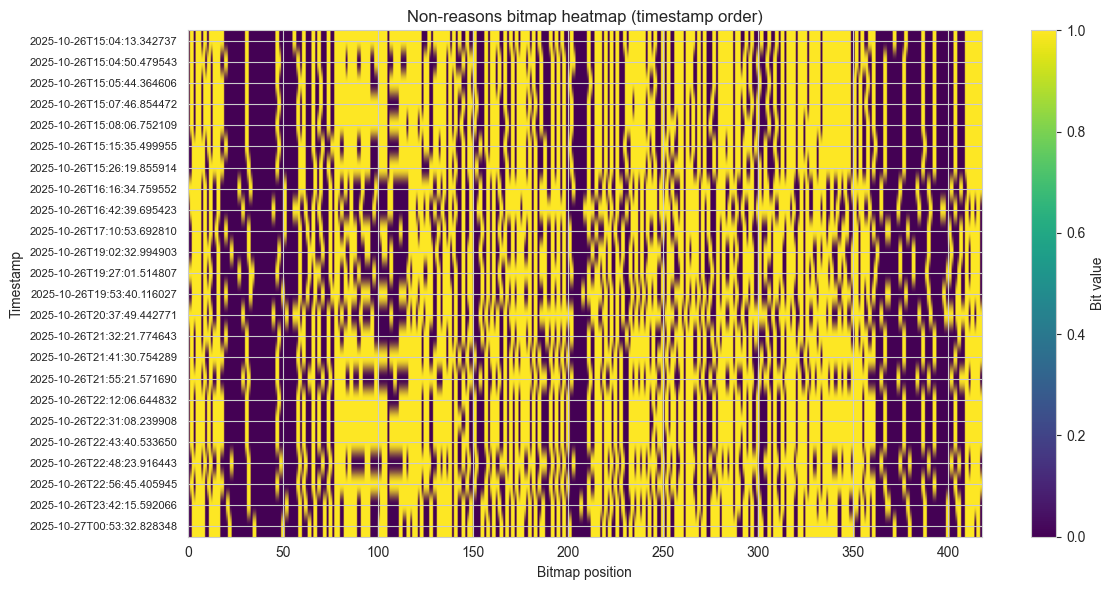

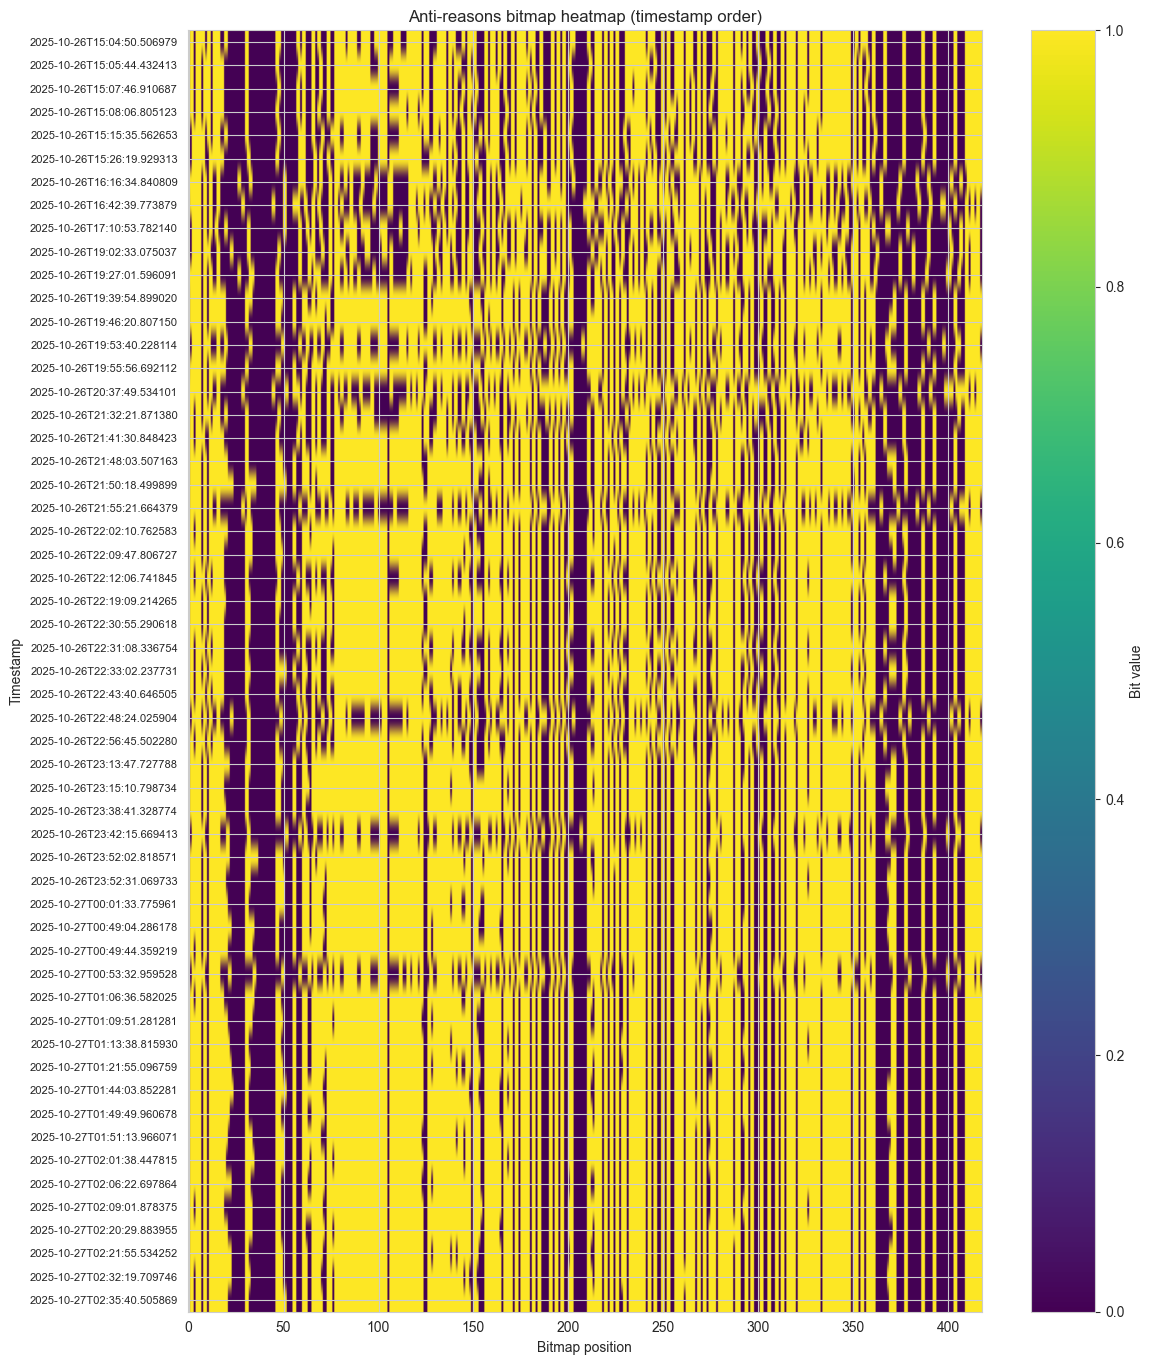

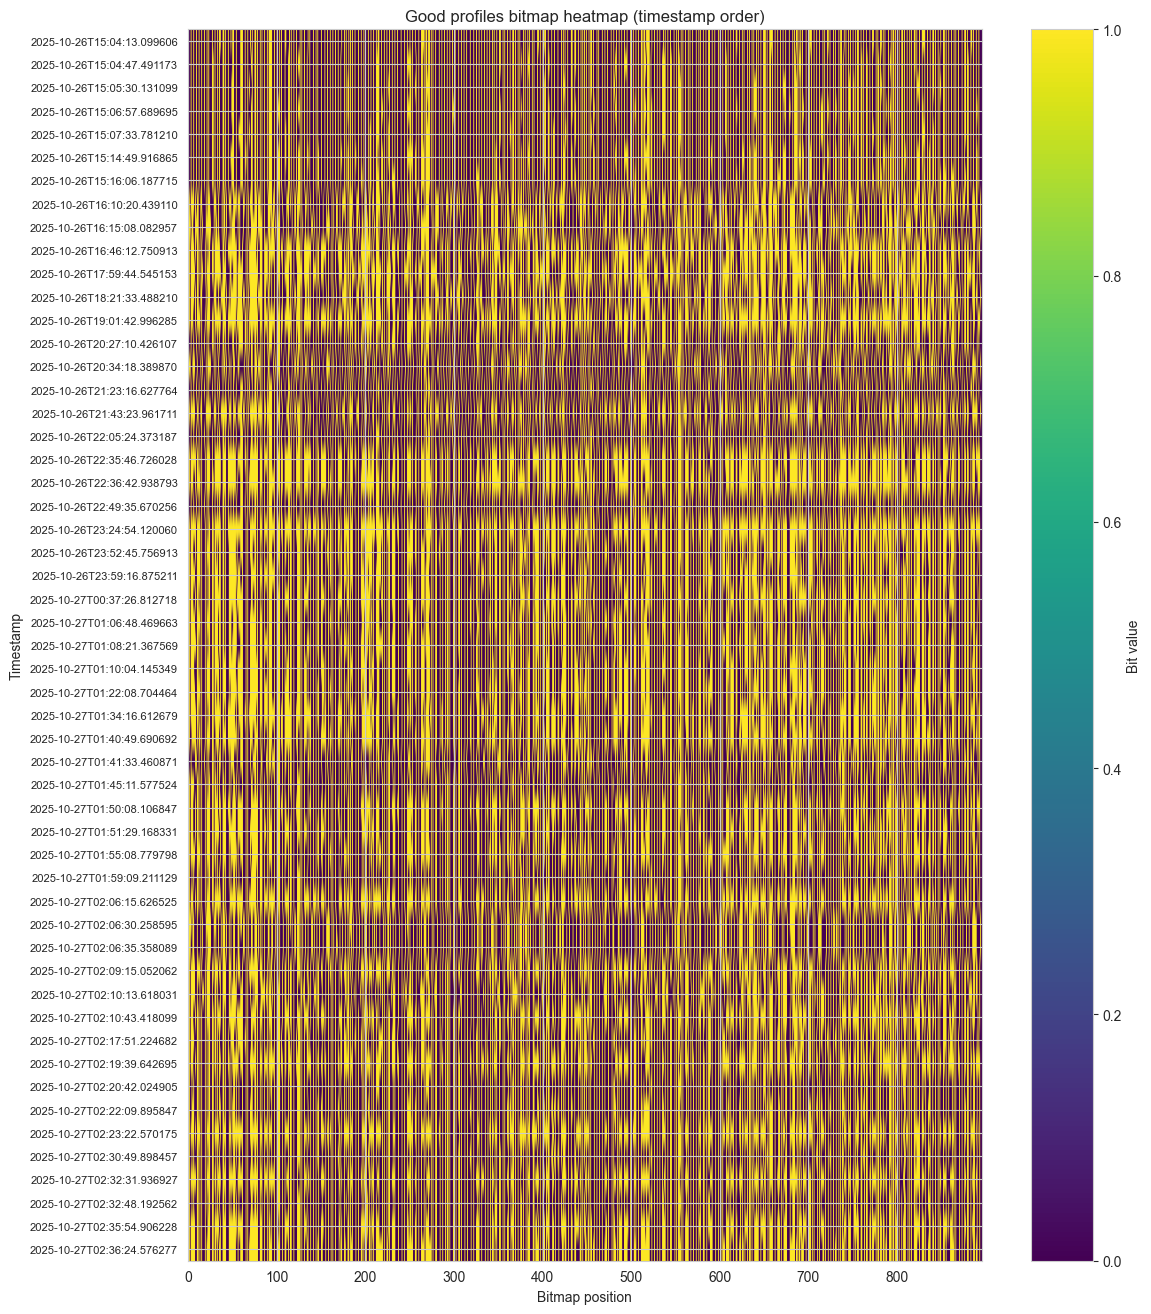

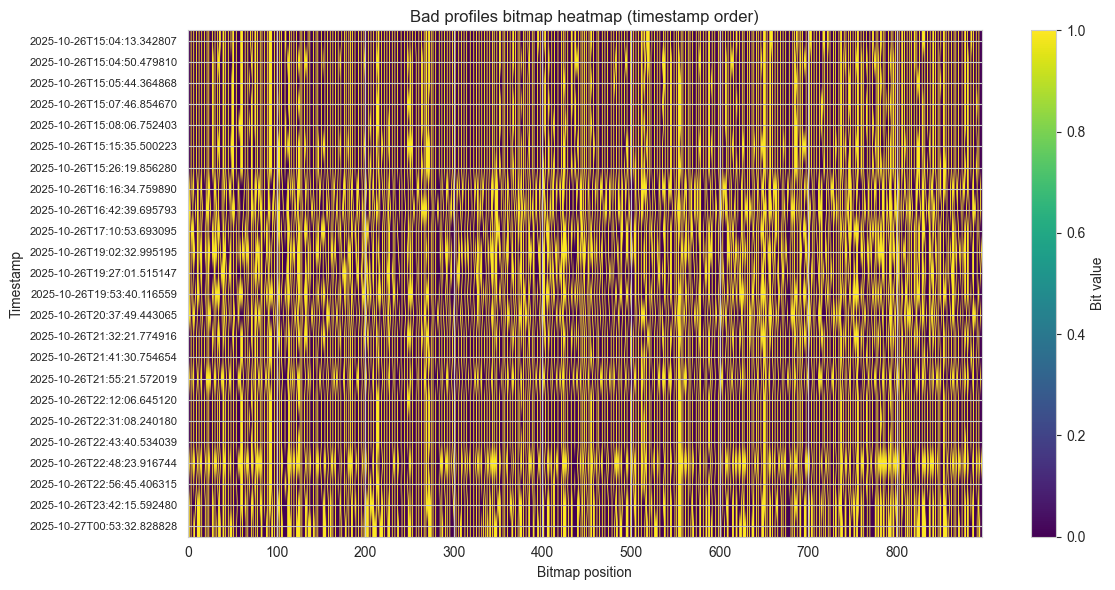

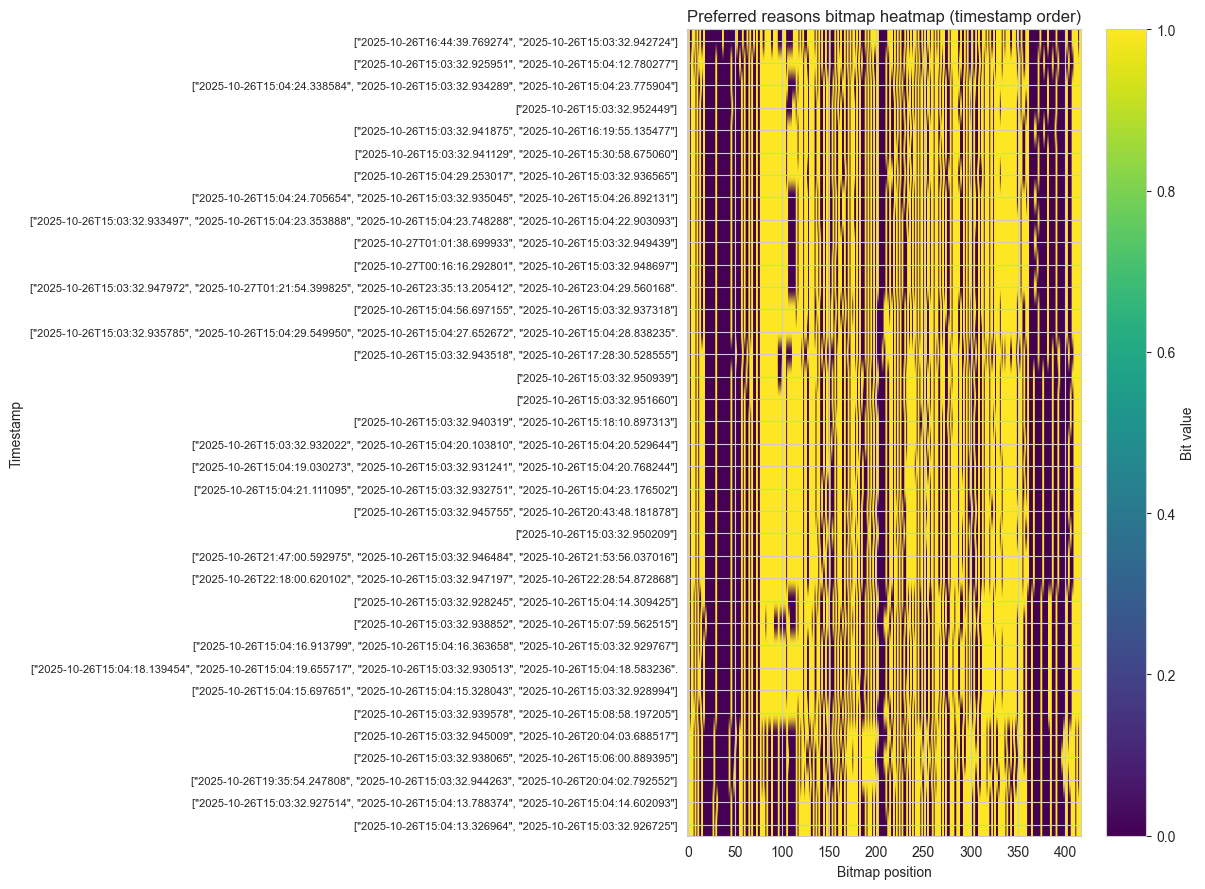

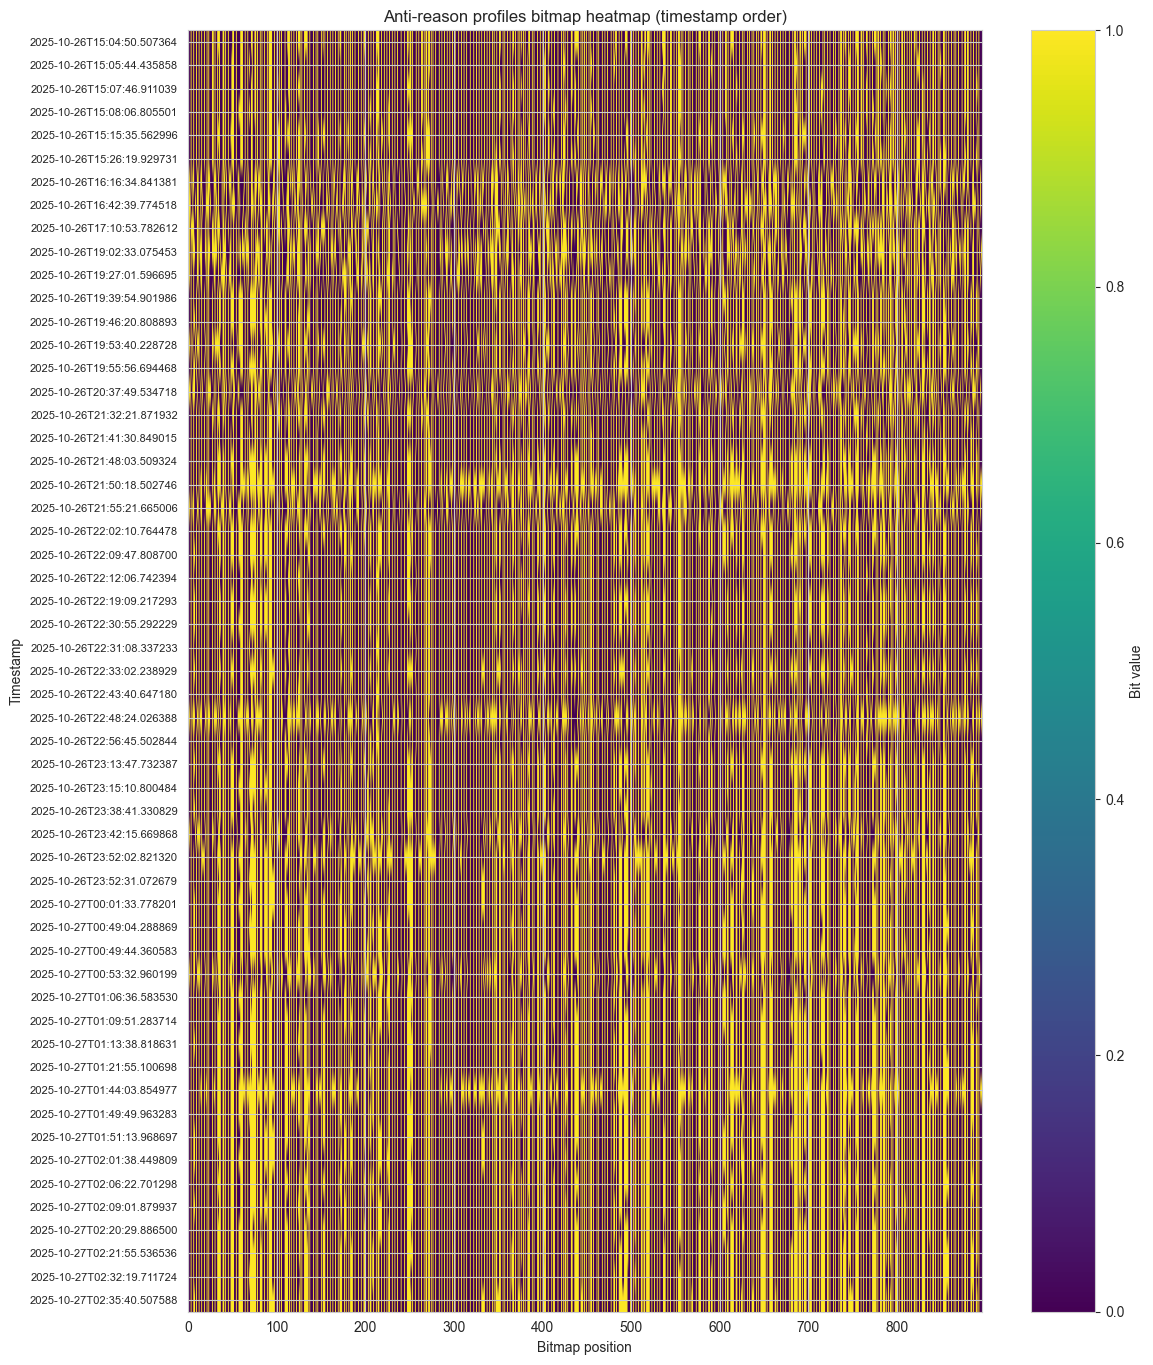

In [7]:
render_bitmap_heatmaps(selected_manifest, selected_backups)